# Universal Probabilistic Programming Example

by Lukas Heinrich


Markov Chains are sequences of random variables, where the value of the current sequence index only depends on the value just before it. Given a current position, the next position is simply defined by a probability distribution p(z,z').

Here we look at a Markov Chain starting at `[0,0]`, which at each point can make exactly two moves "up" and "down".

If you just let the Markov Chain run freely, we will it be after 10 iteratinos? or 20? or 100? You might have heard about the Galton Board.

Before we start, we will import some libraries as always

In [1]:
import pyprob
%matplotlib inline
import matplotlib.pyplot as plt
from pyprob import Model
import numpy as np

import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Categorical
import torch
import IPython


In [2]:
IPython.display.Image(url = 'https://thumbs.gfycat.com/QuaintTidyCockatiel-max-1mb.gif')

## Implementing the Galton Board in Code

we will have a Galton board with 20 steps. At each step the position can move either up and down in a fair way.

In [3]:
class MarkovChainPath(Model):
    def __init__(self):
        super().__init__(name="Markov Chain Path") # give the model a name

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        coords = [[0,0]]
        moves = {0: -1, 1: 1, 2: 1}
        for i in range(1,20):
            last = coords[-1][1]
            move = pyprob.sample(Categorical([1/2.,1/2.]), name = 'input{}'.format(i))
            move = moves[move.item()]
            coords.append([i,last+move])

        obs_distr = Normal(coords[-1][1], 0.1)
        pyprob.observe(obs_distr, name='obs0') # NOTE: observe -> denotes observable variables
        return coords

model = MarkovChainPath()

## Learning to Guide the Chain

As usual we will be training our inference network!

In [4]:
model.learn_inference_network(
    num_traces=10000,
    observe_embeddings={'obs0': {'dim': 100, 'depth': 5}}
)

Creating new inference network...
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observe embedding dimension: 100
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
New layers, address: 74__forward__move__Categorical(len_probs:2)__1, distribution: Categorical
New layers, address: 74__forward__move__Categorical(len_probs:2)__2, distribution: Categorical
New layers, address: 74__forward__move__Categorical(len_probs:2)__3, distribution: Categorical
New layers, address: 74__forward__move__Categorical(len_probs:2)__4, distribution: Categorical
New layers, address: 74__forward__move__Categorical(len_probs:2)__5, distribution: Categorical
New layers, address: 74__forward__move__Categorical(len_probs:2)__6, distribution: Categorical
New layers, address: 74__forward__move__Categorical(len_probs:2)__7, distribution: Categorical
New layers, address: 74__forward__move__Categorical(len_probs:2)__8, distribution: Categorica

## Generating Prior and Posterior Traces

As in the other examples we have prior and posterior traces. What will they look like? Have a guess.

In [5]:
prior = model.prior(
    num_traces=1000,
)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 1000/1000 | 229.92       


We will also generate some sampled from the **conditioned** model. Feel free to change the condition value from 5 to a number you like.

In [14]:
condition = {'obs0': 5}
posterior = model.posterior(
    num_traces=1000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe=condition
)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:18 | 0d:00:00:00 | #################### | 1000/1000 | 53.91       


Let's get a representative set of paths for both the **conditioned** model as well as the **unconditioned** one

In [15]:
post_paths  = [posterior.sample().result for i in range(1000)]
prior_paths = [prior.sample().result for i in range(1000)]

### The Plots!

As expected the conoditioned paths always arrive at the same spot, no matter where they wandered off to in the middle of their path. At some point the proposals from the agent will steer it in the correct direction.


We can also plot the final position distribution. As expected the unconditinoed one follows a normal distribution while the conditioned one, is basically a delta distribution on the conditioned value

Text(0, 0.5, 'position')

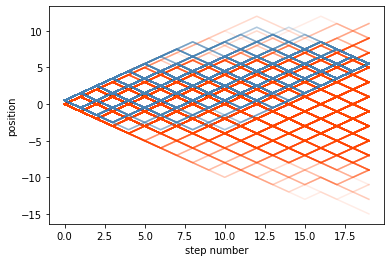

In [16]:
for p in prior_paths:
    p = np.asarray(p)
    plt.plot(p[:,0],p[:,1], c = 'orangered', alpha = 0.1)    
    
    
for p in post_paths:
    p = np.asarray(p)
    plt.plot(p[:,0],p[:,1] + 0.5, c = 'steelblue', alpha = 0.1, )
plt.xlabel('step number')
plt.ylabel('position')

Text(0.5, 0, 'final position')

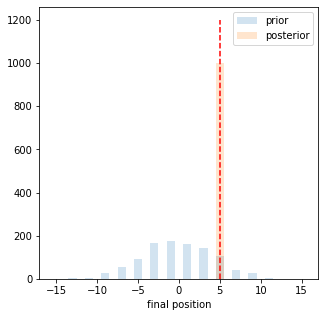

In [17]:
c1,_,_ = plt.hist([p[-1][1] for p in prior_paths], np.linspace(-15.5,15.5,32), alpha = 0.2, label = 'prior');
c2,_,_ = plt.hist([p[-1][1] for p in post_paths], np.linspace(-15.5,15.5,32), alpha = 0.2, label = 'posterior');
plt.vlines(condition['obs0'],0,np.max([c1.max(),c2.max()])*1.2, linestyle = 'dashed', color = 'red')
plt.legend()
plt.gcf().set_size_inches(5,5)
plt.xlabel('final position')